In [1]:
import os
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from neuralforecast import NeuralForecast
from neuralforecast.models import TimeLLM
from neuralforecast.losses.pytorch import RMSE
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic, augment_calendar_df
from transformers import GPT2Config, GPT2Model, GPT2Tokenizer, BertConfig, BertModel, BertTokenizer

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
y_scaler = MinMaxScaler()
trend_scaler = MinMaxScaler()
lag_scaler = MinMaxScaler()

horizon = 12
torch.set_float32_matmul_precision('medium')

In [3]:
AirPassengersPanel, calendar_cols = augment_calendar_df(df=AirPassengersPanel, freq='M')


In [4]:
AirPassengersPanel

,unique_id,ds,y,trend,y_[lag12],month
0,Airline1,1949-01-31,112.0,0,112.0,-0.500000
1,Airline1,1949-02-28,118.0,1,118.0,-0.409091
2,Airline1,1949-03-31,132.0,2,132.0,-0.318182
3,Airline1,1949-04-30,129.0,3,129.0,-0.227273
4,Airline1,1949-05-31,121.0,4,121.0,-0.136364
...,...,...,...,...,...,...
283,Airline2,1960-08-31,906.0,283,859.0,0.136364
284,Airline2,1960-09-30,808.0,284,763.0,0.227273
285,Airline2,1960-10-31,761.0,285,707.0,0.318182
286,Airline2,1960-11-30,690.0,286,662.0,0.409091


In [5]:
AirPassengersPanel['y'] = y_scaler.fit_transform(AirPassengersPanel[['y']])
AirPassengersPanel['trend'] = trend_scaler.fit_transform(AirPassengersPanel[['trend']])
AirPassengersPanel['y_[lag12]'] = lag_scaler.fit_transform(AirPassengersPanel[['y_[lag12]']])

Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]].copy()
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True).copy()

In [6]:
# gpt2_config = GPT2Config.from_pretrained('openai-community/gpt2')
# gpt2 = GPT2Model.from_pretrained('openai-community/gpt2',config=gpt2_config)
# gpt2_tokenizer = GPT2Tokenizer.from_pretrained('openai-community/bert2')

In [7]:
bert_config = BertConfig.from_pretrained('google-bert/bert-base-uncased')
bert = BertModel.from_pretrained('google-bert/bert-base-uncased', config=bert_config)
bert_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-uncased')

In [8]:
prompt_prefix = (
    "The dataset contains data on monthly air passengers. \n"
    "There is a year positive trend, as well as a month seasonality. \n"
    "Usually around months 6, 7 or 8 there's a spike."
)

In [9]:
timellm_bert = TimeLLM(
    h=horizon,
    input_size=36,
    llm=bert,
    llm_config=bert_config,
    llm_tokenizer=bert_tokenizer,
    prompt_prefix=prompt_prefix,
    llm_num_hidden_layers=48,
    max_steps=1000,
    batch_size=24,
    windows_batch_size=1,
    num_workers_loader=15,
)


/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'llm' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['llm'])`.
Seed set to 1
Using eos_token, but it is not set yet.


In [10]:
# timellm_gpt2 = TimeLLM(
#     h=horizon,
#     input_size=36,
#     llm=gpt2,
#     llm_config=gpt2_config,
#     llm_tokenizer=gpt2_tokenizer,
#     prompt_prefix=prompt_prefix,
#     llm_num_hidden_layers=48,
#     max_steps=1000,
#     batch_size=24,
#     windows_batch_size=1,
#     num_workers_loader=15,
# )


In [11]:
nf = NeuralForecast(
    # models=[timellm_gpt2],
    models=[timellm_bert],
    freq='M',
    
)

nf.fit(df=Y_train_df, val_size=horizon, verbose=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type               | Params
-----------------------------------------------------------
0 | loss                | MAE                | 0     
1 | padder_train        | ConstantPad1d      | 0     
2 | scaler              | TemporalNorm       | 0     
3 | llm                 | BertModel          | 109 M 
4 | patch_embedding     | PatchEmbedding     | 1.5 K 
5 | mapping_layer       | Linear             | 31.3 M
6 | reprogramming_layer | ReprogrammingLayer | 2.4 M 
7 | output_projection   | FlattenHead        | 6.2 K 
8 | normalize_layers    | Normalize          | 0     
-----------------------------------------------------------
33.7 M    Trainable params
109 M     Non-trainable params
143 M     Total params
572.566   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training:   0%|          | 0/1 [00:00<?, ?it/s]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0853, train_loss_epoch=0.0853]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0301, train_loss_epoch=0.0301]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 3:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0715, train_loss_epoch=0.0715]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 4:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0762, train_loss_epoch=0.0762]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 5:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0937, train_loss_epoch=0.0937]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 6:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.052, train_loss_epoch=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 7:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0936, train_loss_epoch=0.0936]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 8:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0859, train_loss_epoch=0.0859]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 9:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0546, train_loss_epoch=0.0546]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 10:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0493, train_loss_epoch=0.0493]       

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 11:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0505, train_loss_epoch=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 12:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0485, train_loss_epoch=0.0485]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 13:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0504, train_loss_epoch=0.0504]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 14:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0447, train_loss_epoch=0.0447]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 15:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0473, train_loss_epoch=0.0473]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 16:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0408, train_loss_epoch=0.0408]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0427, train_loss_epoch=0.0427]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 18:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0781, train_loss_epoch=0.0781]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 19:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0437, train_loss_epoch=0.0437]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 20:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0626, train_loss_epoch=0.0626]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 21:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0579, train_loss_epoch=0.0579]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 22:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0452, train_loss_epoch=0.0452]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 23:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0394, train_loss_epoch=0.0394]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 24:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0596, train_loss_epoch=0.0596]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 25:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.061, train_loss_epoch=0.061]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 26:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.033, train_loss_epoch=0.033]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 27:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0396, train_loss_epoch=0.0396]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 28:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0741, train_loss_epoch=0.0741]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 29:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.040, train_loss_epoch=0.040]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 30:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0394, train_loss_epoch=0.0394]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 31:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0779, train_loss_epoch=0.0779]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 32:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0406, train_loss_epoch=0.0406]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 33:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0392, train_loss_epoch=0.0392]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 34:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0794, train_loss_epoch=0.0794]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 35:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0635, train_loss_epoch=0.0635]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 36:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0468, train_loss_epoch=0.0468]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 37:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.077, train_loss_epoch=0.077]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 38:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0818, train_loss_epoch=0.0818]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 39:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0644, train_loss_epoch=0.0644]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 40:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0384, train_loss_epoch=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 41:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0752, train_loss_epoch=0.0752]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 42:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 43:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0588, train_loss_epoch=0.0588]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 44:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0596, train_loss_epoch=0.0596]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 45:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0346, train_loss_epoch=0.0346]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 46:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0448, train_loss_epoch=0.0448]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 47:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0378, train_loss_epoch=0.0378]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 48:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0495, train_loss_epoch=0.0495]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 49:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0545, train_loss_epoch=0.0545]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 50:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0705, train_loss_epoch=0.0705]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 51:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0453, train_loss_epoch=0.0453]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 52:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0532, train_loss_epoch=0.0532]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 53:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0645, train_loss_epoch=0.0645]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 54:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0376, train_loss_epoch=0.0376]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 55:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0443, train_loss_epoch=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 56:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0417, train_loss_epoch=0.0417]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 57:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0342, train_loss_epoch=0.0342]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 58:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0618, train_loss_epoch=0.0618]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 59:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0614, train_loss_epoch=0.0614]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 60:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0572, train_loss_epoch=0.0572]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 61:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0382, train_loss_epoch=0.0382]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 62:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0361, train_loss_epoch=0.0361]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 63:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0579, train_loss_epoch=0.0579]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 64:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0793, train_loss_epoch=0.0793]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 65:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0482, train_loss_epoch=0.0482]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 66:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0387, train_loss_epoch=0.0387]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 67:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 68:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.122, train_loss_epoch=0.122]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 69:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0776, train_loss_epoch=0.0776]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 70:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0515, train_loss_epoch=0.0515]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 71:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0463, train_loss_epoch=0.0463]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 72:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0429, train_loss_epoch=0.0429]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 73:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0331, train_loss_epoch=0.0331]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 74:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0717, train_loss_epoch=0.0717]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 75:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 76:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0628, train_loss_epoch=0.0628]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 77:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0327, train_loss_epoch=0.0327]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 78:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0454, train_loss_epoch=0.0454]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 79:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.049, train_loss_epoch=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 80:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0297, train_loss_epoch=0.0297]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 81:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0731, train_loss_epoch=0.0731]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 82:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0504, train_loss_epoch=0.0504]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 83:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0542, train_loss_epoch=0.0542]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 84:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0554, train_loss_epoch=0.0554]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 85:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0321, train_loss_epoch=0.0321]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 86:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0465, train_loss_epoch=0.0465]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 87:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.054, train_loss_epoch=0.054]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 88:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0468, train_loss_epoch=0.0468]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 89:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 90:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0407, train_loss_epoch=0.0407]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 91:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0678, train_loss_epoch=0.0678]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 92:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 93:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0532, train_loss_epoch=0.0532]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 94:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0311, train_loss_epoch=0.0311]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 95:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0435, train_loss_epoch=0.0435]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 96:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0677, train_loss_epoch=0.0677]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 97:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0315, train_loss_epoch=0.0315]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 98:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0592, train_loss_epoch=0.0592]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 99:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0835, train_loss_epoch=0.0835]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=6, train_loss_step=0.0758, train_loss_epoch=0.0835]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 100:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0758, train_loss_epoch=0.0758, valid_loss=0.052]       

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 101:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0497, train_loss_epoch=0.0497, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 102:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0603, train_loss_epoch=0.0603, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 103:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0774, train_loss_epoch=0.0774, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 104:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0415, train_loss_epoch=0.0415, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 105:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0546, train_loss_epoch=0.0546, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 106:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0318, train_loss_epoch=0.0318, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 107:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0308, train_loss_epoch=0.0308, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 108:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0658, train_loss_epoch=0.0658, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 109:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 110:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0513, train_loss_epoch=0.0513, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 111:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0482, train_loss_epoch=0.0482, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 112:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0445, train_loss_epoch=0.0445, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 113:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0341, train_loss_epoch=0.0341, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 114:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0272, train_loss_epoch=0.0272, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 115:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0469, train_loss_epoch=0.0469, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 116:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.075, train_loss_epoch=0.075, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 117:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0386, train_loss_epoch=0.0386, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 118:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 119:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0349, train_loss_epoch=0.0349, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 120:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0567, train_loss_epoch=0.0567, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 121:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0398, train_loss_epoch=0.0398, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 122:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 123:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0596, train_loss_epoch=0.0596, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 124:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0456, train_loss_epoch=0.0456, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 125:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 126:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0347, train_loss_epoch=0.0347, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 127:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0326, train_loss_epoch=0.0326, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 128:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0393, train_loss_epoch=0.0393, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 129:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 130:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0356, train_loss_epoch=0.0356, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 131:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0423, train_loss_epoch=0.0423, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 132:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0438, train_loss_epoch=0.0438, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 133:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 134:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 135:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0455, train_loss_epoch=0.0455, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 136:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0467, train_loss_epoch=0.0467, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 137:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0619, train_loss_epoch=0.0619, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 138:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0328, train_loss_epoch=0.0328, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 139:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0444, train_loss_epoch=0.0444, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 140:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0274, train_loss_epoch=0.0274, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 141:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0476, train_loss_epoch=0.0476, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 142:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0532, train_loss_epoch=0.0532, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 143:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 144:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0358, train_loss_epoch=0.0358, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 145:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0472, train_loss_epoch=0.0472, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 146:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0507, train_loss_epoch=0.0507, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 147:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0471, train_loss_epoch=0.0471, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 148:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0368, train_loss_epoch=0.0368, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 149:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0403, train_loss_epoch=0.0403, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 150:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 151:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.017, train_loss_epoch=0.017, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 152:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 153:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0438, train_loss_epoch=0.0438, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 154:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0197, train_loss_epoch=0.0197, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 155:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0222, train_loss_epoch=0.0222, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 156:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0477, train_loss_epoch=0.0477, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 157:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0284, train_loss_epoch=0.0284, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 158:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0265, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 159:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0268, train_loss_epoch=0.0268, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 160:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0262, train_loss_epoch=0.0262, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 161:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0277, train_loss_epoch=0.0277, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 162:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 163:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0639, train_loss_epoch=0.0639, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 164:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0304, train_loss_epoch=0.0304, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 165:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0449, train_loss_epoch=0.0449, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 166:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0143, train_loss_epoch=0.0143, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 167:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0337, train_loss_epoch=0.0337, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 168:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0389, train_loss_epoch=0.0389, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 169:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0488, train_loss_epoch=0.0488, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 170:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0407, train_loss_epoch=0.0407, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 171:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0395, train_loss_epoch=0.0395, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 172:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0419, train_loss_epoch=0.0419, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 173:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0313, train_loss_epoch=0.0313, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 174:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 175:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0397, train_loss_epoch=0.0397, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 176:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0419, train_loss_epoch=0.0419, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 177:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 178:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0437, train_loss_epoch=0.0437, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 179:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0233, train_loss_epoch=0.0233, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 180:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0265, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 181:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0554, train_loss_epoch=0.0554, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 182:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0248, train_loss_epoch=0.0248, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 183:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0188, train_loss_epoch=0.0188, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 184:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.037, train_loss_epoch=0.037, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 185:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0434, train_loss_epoch=0.0434, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 186:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0594, train_loss_epoch=0.0594, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 187:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0315, train_loss_epoch=0.0315, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 188:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 189:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0561, train_loss_epoch=0.0561, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 190:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0287, train_loss_epoch=0.0287, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 191:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0289, train_loss_epoch=0.0289, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 192:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0697, train_loss_epoch=0.0697, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 193:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.071, train_loss_epoch=0.071, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 194:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0467, train_loss_epoch=0.0467, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 195:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0363, train_loss_epoch=0.0363, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 196:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 197:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0569, train_loss_epoch=0.0569, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 198:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.052]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 199:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.046, train_loss_epoch=0.046, valid_loss=0.052]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 199: 100%|██████████| 1/1 [00:00<00:00,  1.61it/s, v_num=6, train_loss_step=0.0256, train_loss_epoch=0.046, valid_loss=0.052]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 200:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0256, train_loss_epoch=0.0256, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 201:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.031, train_loss_epoch=0.031, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 202:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.110, train_loss_epoch=0.110, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 203:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0278, train_loss_epoch=0.0278, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 204:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0379, train_loss_epoch=0.0379, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 205:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 206:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0326, train_loss_epoch=0.0326, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 207:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0297, train_loss_epoch=0.0297, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 208:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0278, train_loss_epoch=0.0278, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 209:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0258, train_loss_epoch=0.0258, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 210:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 211:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0303, train_loss_epoch=0.0303, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 212:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0574, train_loss_epoch=0.0574, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 213:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0318, train_loss_epoch=0.0318, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 214:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 215:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.036, train_loss_epoch=0.036, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 216:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 217:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0302, train_loss_epoch=0.0302, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 218:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0418, train_loss_epoch=0.0418, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 219:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0259, train_loss_epoch=0.0259, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 220:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0431, train_loss_epoch=0.0431, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 221:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0588, train_loss_epoch=0.0588, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 222:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0377, train_loss_epoch=0.0377, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 223:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0294, train_loss_epoch=0.0294, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 224:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0217, train_loss_epoch=0.0217, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 225:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0612, train_loss_epoch=0.0612, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 226:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0374, train_loss_epoch=0.0374, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 227:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0312, train_loss_epoch=0.0312, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 228:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0186, train_loss_epoch=0.0186, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 229:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0277, train_loss_epoch=0.0277, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 230:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0556, train_loss_epoch=0.0556, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 231:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0473, train_loss_epoch=0.0473, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 232:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0479, train_loss_epoch=0.0479, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 233:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0399, train_loss_epoch=0.0399, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 234:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0634, train_loss_epoch=0.0634, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 235:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0471, train_loss_epoch=0.0471, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 236:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.030, train_loss_epoch=0.030, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 237:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.016, train_loss_epoch=0.016, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 238:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0382, train_loss_epoch=0.0382, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 239:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0298, train_loss_epoch=0.0298, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 240:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0194, train_loss_epoch=0.0194, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 241:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.051, train_loss_epoch=0.051, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 242:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0316, train_loss_epoch=0.0316, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 243:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0415, train_loss_epoch=0.0415, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 244:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 245:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0244, train_loss_epoch=0.0244, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 246:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.023, train_loss_epoch=0.023, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 247:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0742, train_loss_epoch=0.0742, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 248:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0387, train_loss_epoch=0.0387, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 249:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0229, train_loss_epoch=0.0229, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 250:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0299, train_loss_epoch=0.0299, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 251:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 252:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0238, train_loss_epoch=0.0238, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 253:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 254:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0551, train_loss_epoch=0.0551, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 255:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0246, train_loss_epoch=0.0246, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 256:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0543, train_loss_epoch=0.0543, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 257:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0257, train_loss_epoch=0.0257, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 258:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.019, train_loss_epoch=0.019, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 259:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 260:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0574, train_loss_epoch=0.0574, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 261:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0381, train_loss_epoch=0.0381, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 262:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0276, train_loss_epoch=0.0276, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 263:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0307, train_loss_epoch=0.0307, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 264:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.035, train_loss_epoch=0.035, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 265:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0352, train_loss_epoch=0.0352, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 266:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0223, train_loss_epoch=0.0223, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 267:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 268:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0536, train_loss_epoch=0.0536, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 269:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0232, train_loss_epoch=0.0232, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 270:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0134, train_loss_epoch=0.0134, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 271:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.034, train_loss_epoch=0.034, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 272:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 273:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0115, train_loss_epoch=0.0115, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 274:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0316, train_loss_epoch=0.0316, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 275:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0217, train_loss_epoch=0.0217, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 276:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0579, train_loss_epoch=0.0579, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 277:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0214, train_loss_epoch=0.0214, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 278:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.020, train_loss_epoch=0.020, valid_loss=0.056]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 279:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0208, train_loss_epoch=0.0208, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 280:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0198, train_loss_epoch=0.0198, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 281:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0302, train_loss_epoch=0.0302, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 282:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0252, train_loss_epoch=0.0252, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 283:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0544, train_loss_epoch=0.0544, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 284:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0261, train_loss_epoch=0.0261, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 285:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0447, train_loss_epoch=0.0447, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 286:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0368, train_loss_epoch=0.0368, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 287:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0166, train_loss_epoch=0.0166, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 288:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0242, train_loss_epoch=0.0242, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 289:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0533, train_loss_epoch=0.0533, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 290:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 291:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0496, train_loss_epoch=0.0496, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 292:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0224, train_loss_epoch=0.0224, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 293:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0227, train_loss_epoch=0.0227, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 294:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0273, train_loss_epoch=0.0273, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 295:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 296:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0553, train_loss_epoch=0.0553, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 297:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 298:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 299:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0263, train_loss_epoch=0.0263, valid_loss=0.056]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0263, valid_loss=0.056]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 300:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 301:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 302:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0175, train_loss_epoch=0.0175, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 303:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0395, train_loss_epoch=0.0395, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 304:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 305:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 306:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 307:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0282, train_loss_epoch=0.0282, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 308:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 309:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0159, train_loss_epoch=0.0159, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 310:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0385, train_loss_epoch=0.0385, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 311:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0284, train_loss_epoch=0.0284, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 312:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0384, train_loss_epoch=0.0384, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 313:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0283, train_loss_epoch=0.0283, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 314:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0423, train_loss_epoch=0.0423, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 315:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0341, train_loss_epoch=0.0341, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 316:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0288, train_loss_epoch=0.0288, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 317:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0339, train_loss_epoch=0.0339, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 318:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 319:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.023, train_loss_epoch=0.023, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 320:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0443, train_loss_epoch=0.0443, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 321:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0188, train_loss_epoch=0.0188, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 322:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0187, train_loss_epoch=0.0187, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 323:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 324:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0297, train_loss_epoch=0.0297, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 325:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0635, train_loss_epoch=0.0635, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 326:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 327:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 328:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0508, train_loss_epoch=0.0508, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 329:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0242, train_loss_epoch=0.0242, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 330:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 331:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0313, train_loss_epoch=0.0313, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 332:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.027, train_loss_epoch=0.027, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 333:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0367, train_loss_epoch=0.0367, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 334:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.019, train_loss_epoch=0.019, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 335:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.020, train_loss_epoch=0.020, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 336:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0409, train_loss_epoch=0.0409, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 337:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 338:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 339:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 340:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0226, train_loss_epoch=0.0226, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 341:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0178, train_loss_epoch=0.0178, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 342:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0287, train_loss_epoch=0.0287, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 343:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0408, train_loss_epoch=0.0408, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 344:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0237, train_loss_epoch=0.0237, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 345:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.018, train_loss_epoch=0.018, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 346:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0301, train_loss_epoch=0.0301, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 347:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 348:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0372, train_loss_epoch=0.0372, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 349:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0414, train_loss_epoch=0.0414, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 350:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0352, train_loss_epoch=0.0352, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 351:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0314, train_loss_epoch=0.0314, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 352:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.014, train_loss_epoch=0.014, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 353:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 354:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0344, train_loss_epoch=0.0344, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 355:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0213, train_loss_epoch=0.0213, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 356:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 357:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0257, train_loss_epoch=0.0257, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 358:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0496, train_loss_epoch=0.0496, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 359:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 360:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0151, train_loss_epoch=0.0151, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 361:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 362:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0333, train_loss_epoch=0.0333, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 363:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0259, train_loss_epoch=0.0259, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 364:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 365:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0203, train_loss_epoch=0.0203, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 366:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0257, train_loss_epoch=0.0257, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 367:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0286, train_loss_epoch=0.0286, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 368:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0193, train_loss_epoch=0.0193, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 369:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0351, train_loss_epoch=0.0351, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 370:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0502, train_loss_epoch=0.0502, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 371:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0287, train_loss_epoch=0.0287, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 372:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0314, train_loss_epoch=0.0314, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 373:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0316, train_loss_epoch=0.0316, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 374:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0333, train_loss_epoch=0.0333, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 375:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.012, train_loss_epoch=0.012, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 376:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0543, train_loss_epoch=0.0543, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 377:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.040, train_loss_epoch=0.040, valid_loss=0.049]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 378:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0327, train_loss_epoch=0.0327, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 379:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0345, train_loss_epoch=0.0345, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 380:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0397, train_loss_epoch=0.0397, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 381:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 382:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 383:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0438, train_loss_epoch=0.0438, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 384:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0192, train_loss_epoch=0.0192, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 385:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0265, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 386:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0307, train_loss_epoch=0.0307, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 387:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0149, train_loss_epoch=0.0149, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 388:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0251, train_loss_epoch=0.0251, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 389:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0298, train_loss_epoch=0.0298, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 390:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 391:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0297, train_loss_epoch=0.0297, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 392:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0591, train_loss_epoch=0.0591, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 393:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0649, train_loss_epoch=0.0649, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 394:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0412, train_loss_epoch=0.0412, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 395:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0313, train_loss_epoch=0.0313, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 396:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0374, train_loss_epoch=0.0374, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 397:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0758, train_loss_epoch=0.0758, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 398:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0159, train_loss_epoch=0.0159, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 399:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0418, train_loss_epoch=0.0418, valid_loss=0.049]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 399: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s, v_num=6, train_loss_step=0.0324, train_loss_epoch=0.0418, valid_loss=0.049]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 400:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 401:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0275, train_loss_epoch=0.0275, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 402:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0398, train_loss_epoch=0.0398, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 403:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0369, train_loss_epoch=0.0369, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 404:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 405:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0156, train_loss_epoch=0.0156, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 406:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0264, train_loss_epoch=0.0264, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 407:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.024, train_loss_epoch=0.024, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 408:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0692, train_loss_epoch=0.0692, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 409:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 410:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0362, train_loss_epoch=0.0362, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 411:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0575, train_loss_epoch=0.0575, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 412:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.045, train_loss_epoch=0.045, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 413:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 414:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 415:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0613, train_loss_epoch=0.0613, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 416:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0259, train_loss_epoch=0.0259, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 417:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0394, train_loss_epoch=0.0394, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 418:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0461, train_loss_epoch=0.0461, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 419:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0401, train_loss_epoch=0.0401, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 420:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0333, train_loss_epoch=0.0333, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 421:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.049, train_loss_epoch=0.049, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 422:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0218, train_loss_epoch=0.0218, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 423:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0318, train_loss_epoch=0.0318, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 424:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0374, train_loss_epoch=0.0374, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 425:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0639, train_loss_epoch=0.0639, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 426:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0312, train_loss_epoch=0.0312, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 427:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 428:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0362, train_loss_epoch=0.0362, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 429:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0381, train_loss_epoch=0.0381, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 430:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0391, train_loss_epoch=0.0391, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 431:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0165, train_loss_epoch=0.0165, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 432:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0301, train_loss_epoch=0.0301, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 433:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0203, train_loss_epoch=0.0203, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 434:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0444, train_loss_epoch=0.0444, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 435:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.022, train_loss_epoch=0.022, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 436:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0263, train_loss_epoch=0.0263, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 437:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0497, train_loss_epoch=0.0497, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 438:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0184, train_loss_epoch=0.0184, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 439:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.041, train_loss_epoch=0.041, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 440:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0328, train_loss_epoch=0.0328, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 441:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0308, train_loss_epoch=0.0308, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 442:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0294, train_loss_epoch=0.0294, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 443:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0272, train_loss_epoch=0.0272, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 444:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0325, train_loss_epoch=0.0325, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 445:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0389, train_loss_epoch=0.0389, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 446:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.019, train_loss_epoch=0.019, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 447:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0218, train_loss_epoch=0.0218, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 448:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0273, train_loss_epoch=0.0273, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 449:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0327, train_loss_epoch=0.0327, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 450:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0178, train_loss_epoch=0.0178, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 451:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0238, train_loss_epoch=0.0238, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 452:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0286, train_loss_epoch=0.0286, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 453:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0381, train_loss_epoch=0.0381, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 454:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0642, train_loss_epoch=0.0642, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 455:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 456:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0434, train_loss_epoch=0.0434, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 457:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.019, train_loss_epoch=0.019, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 458:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 459:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0148, train_loss_epoch=0.0148, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 460:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0525, train_loss_epoch=0.0525, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 461:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0371, train_loss_epoch=0.0371, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 462:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0339, train_loss_epoch=0.0339, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 463:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0194, train_loss_epoch=0.0194, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 464:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 465:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0151, train_loss_epoch=0.0151, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 466:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0213, train_loss_epoch=0.0213, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 467:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0458, train_loss_epoch=0.0458, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 468:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0107, train_loss_epoch=0.0107, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 469:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0533, train_loss_epoch=0.0533, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 470:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 471:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0205, train_loss_epoch=0.0205, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 472:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0286, train_loss_epoch=0.0286, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 473:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0394, train_loss_epoch=0.0394, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 474:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 475:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0355, train_loss_epoch=0.0355, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 476:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 477:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0187, train_loss_epoch=0.0187, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 478:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0283, train_loss_epoch=0.0283, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 479:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0441, train_loss_epoch=0.0441, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 480:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0567, train_loss_epoch=0.0567, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 481:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0256, train_loss_epoch=0.0256, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 482:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0277, train_loss_epoch=0.0277, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 483:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0293, train_loss_epoch=0.0293, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 484:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0463, train_loss_epoch=0.0463, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 485:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0527, train_loss_epoch=0.0527, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 486:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.050, train_loss_epoch=0.050, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 487:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0462, train_loss_epoch=0.0462, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 488:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0385, train_loss_epoch=0.0385, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 489:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.029, train_loss_epoch=0.029, valid_loss=0.0409]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 490:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0338, train_loss_epoch=0.0338, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 491:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0552, train_loss_epoch=0.0552, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 492:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 493:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0316, train_loss_epoch=0.0316, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 494:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0279, train_loss_epoch=0.0279, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 495:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0277, train_loss_epoch=0.0277, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 496:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 497:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0498, train_loss_epoch=0.0498, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 498:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 499:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0431, train_loss_epoch=0.0431, valid_loss=0.0409]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 499: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s, v_num=6, train_loss_step=0.0476, train_loss_epoch=0.0431, valid_loss=0.0409]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 500:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0476, train_loss_epoch=0.0476, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 501:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0303, train_loss_epoch=0.0303, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 502:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.025, train_loss_epoch=0.025, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 503:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0468, train_loss_epoch=0.0468, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 504:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0344, train_loss_epoch=0.0344, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 505:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0361, train_loss_epoch=0.0361, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 506:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0666, train_loss_epoch=0.0666, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 507:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0223, train_loss_epoch=0.0223, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 508:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0607, train_loss_epoch=0.0607, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 509:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0242, train_loss_epoch=0.0242, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 510:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0185, train_loss_epoch=0.0185, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 511:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0397, train_loss_epoch=0.0397, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 512:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0472, train_loss_epoch=0.0472, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 513:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.027, train_loss_epoch=0.027, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 514:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0292, train_loss_epoch=0.0292, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 515:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0543, train_loss_epoch=0.0543, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 516:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0395, train_loss_epoch=0.0395, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 517:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0564, train_loss_epoch=0.0564, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 518:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0471, train_loss_epoch=0.0471, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 519:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0321, train_loss_epoch=0.0321, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 520:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.030, train_loss_epoch=0.030, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 521:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.057, train_loss_epoch=0.057, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 522:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0424, train_loss_epoch=0.0424, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 523:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0242, train_loss_epoch=0.0242, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 524:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 525:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0545, train_loss_epoch=0.0545, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 526:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.016, train_loss_epoch=0.016, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 527:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0558, train_loss_epoch=0.0558, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 528:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0604, train_loss_epoch=0.0604, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 529:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 530:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0281, train_loss_epoch=0.0281, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 531:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0215, train_loss_epoch=0.0215, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 532:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 533:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0288, train_loss_epoch=0.0288, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 534:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0235, train_loss_epoch=0.0235, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 535:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0267, train_loss_epoch=0.0267, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 536:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.042, train_loss_epoch=0.042, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 537:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.030, train_loss_epoch=0.030, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 538:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0241, train_loss_epoch=0.0241, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 539:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.050, train_loss_epoch=0.050, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 540:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0232, train_loss_epoch=0.0232, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 541:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0355, train_loss_epoch=0.0355, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 542:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 543:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0306, train_loss_epoch=0.0306, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 544:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 545:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0271, train_loss_epoch=0.0271, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 546:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0355, train_loss_epoch=0.0355, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 547:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0197, train_loss_epoch=0.0197, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 548:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0252, train_loss_epoch=0.0252, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 549:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0499, train_loss_epoch=0.0499, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 550:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0523, train_loss_epoch=0.0523, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 551:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0133, train_loss_epoch=0.0133, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 552:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0899, train_loss_epoch=0.0899, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 553:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0371, train_loss_epoch=0.0371, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 554:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0168, train_loss_epoch=0.0168, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 555:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.021, train_loss_epoch=0.021, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 556:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0624, train_loss_epoch=0.0624, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 557:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0215, train_loss_epoch=0.0215, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 558:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0255, train_loss_epoch=0.0255, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 559:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.053, train_loss_epoch=0.053, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 560:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0388, train_loss_epoch=0.0388, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 561:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0528, train_loss_epoch=0.0528, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 562:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0426, train_loss_epoch=0.0426, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 563:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0347, train_loss_epoch=0.0347, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 564:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.035, train_loss_epoch=0.035, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 565:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0245, train_loss_epoch=0.0245, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 566:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0208, train_loss_epoch=0.0208, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 567:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 568:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.043, train_loss_epoch=0.043, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 569:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.037, train_loss_epoch=0.037, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 570:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0296, train_loss_epoch=0.0296, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 571:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0385, train_loss_epoch=0.0385, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 572:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0303, train_loss_epoch=0.0303, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 573:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0394, train_loss_epoch=0.0394, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 574:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 575:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.050, train_loss_epoch=0.050, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 576:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0273, train_loss_epoch=0.0273, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 577:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0676, train_loss_epoch=0.0676, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 578:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 579:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0144, train_loss_epoch=0.0144, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 580:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0261, train_loss_epoch=0.0261, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 581:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.036, train_loss_epoch=0.036, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 582:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0239, train_loss_epoch=0.0239, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 583:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0499, train_loss_epoch=0.0499, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 584:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0104, train_loss_epoch=0.0104, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 585:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0376, train_loss_epoch=0.0376, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 586:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0205, train_loss_epoch=0.0205, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 587:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0453, train_loss_epoch=0.0453, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 588:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.032, train_loss_epoch=0.032, valid_loss=0.0505]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 589:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0325, train_loss_epoch=0.0325, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 590:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0415, train_loss_epoch=0.0415, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 591:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0204, train_loss_epoch=0.0204, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 592:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0366, train_loss_epoch=0.0366, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 593:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0536, train_loss_epoch=0.0536, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 594:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0109, train_loss_epoch=0.0109, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 595:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0218, train_loss_epoch=0.0218, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 596:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0568, train_loss_epoch=0.0568, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 597:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0253, train_loss_epoch=0.0253, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 598:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0241, train_loss_epoch=0.0241, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 599:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.00207, train_loss_epoch=0.00207, valid_loss=0.0505]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 599: 100%|██████████| 1/1 [00:00<00:00,  1.54it/s, v_num=6, train_loss_step=0.0295, train_loss_epoch=0.00207, valid_loss=0.0505] 

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 600:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=0.0443]         

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 601:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0331, train_loss_epoch=0.0331, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 602:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.023, train_loss_epoch=0.023, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 603:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0284, train_loss_epoch=0.0284, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 604:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0295, train_loss_epoch=0.0295, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 605:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 606:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.030, train_loss_epoch=0.030, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 607:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.022, train_loss_epoch=0.022, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 608:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0401, train_loss_epoch=0.0401, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 609:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.022, train_loss_epoch=0.022, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 610:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.031, train_loss_epoch=0.031, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 611:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0277, train_loss_epoch=0.0277, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 612:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0226, train_loss_epoch=0.0226, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 613:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0153, train_loss_epoch=0.0153, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 614:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 615:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0341, train_loss_epoch=0.0341, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 616:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0223, train_loss_epoch=0.0223, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 617:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0319, train_loss_epoch=0.0319, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 618:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 619:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0274, train_loss_epoch=0.0274, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 620:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0332, train_loss_epoch=0.0332, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 621:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0603, train_loss_epoch=0.0603, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 622:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0349, train_loss_epoch=0.0349, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 623:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 624:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.026, train_loss_epoch=0.026, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 625:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0176, train_loss_epoch=0.0176, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 626:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0315, train_loss_epoch=0.0315, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 627:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.00976, train_loss_epoch=0.00976, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 628:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0215, train_loss_epoch=0.0215, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 629:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0271, train_loss_epoch=0.0271, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 630:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0575, train_loss_epoch=0.0575, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 631:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0298, train_loss_epoch=0.0298, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 632:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0322, train_loss_epoch=0.0322, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 633:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0373, train_loss_epoch=0.0373, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 634:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0353, train_loss_epoch=0.0353, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 635:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0264, train_loss_epoch=0.0264, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 636:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 637:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0261, train_loss_epoch=0.0261, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 638:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.017, train_loss_epoch=0.017, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 639:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0308, train_loss_epoch=0.0308, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 640:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0304, train_loss_epoch=0.0304, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 641:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0249, train_loss_epoch=0.0249, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 642:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0267, train_loss_epoch=0.0267, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 643:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0221, train_loss_epoch=0.0221, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 644:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0275, train_loss_epoch=0.0275, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 645:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0314, train_loss_epoch=0.0314, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 646:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0199, train_loss_epoch=0.0199, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 647:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0213, train_loss_epoch=0.0213, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 648:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0392, train_loss_epoch=0.0392, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 649:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0204, train_loss_epoch=0.0204, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 650:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0454, train_loss_epoch=0.0454, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 651:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 652:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0456, train_loss_epoch=0.0456, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 653:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0366, train_loss_epoch=0.0366, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 654:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0355, train_loss_epoch=0.0355, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 655:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 656:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0533, train_loss_epoch=0.0533, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 657:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0553, train_loss_epoch=0.0553, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 658:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.037, train_loss_epoch=0.037, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 659:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0258, train_loss_epoch=0.0258, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 660:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0351, train_loss_epoch=0.0351, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 661:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 662:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0399, train_loss_epoch=0.0399, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 663:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.027, train_loss_epoch=0.027, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 664:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 665:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0252, train_loss_epoch=0.0252, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 666:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0249, train_loss_epoch=0.0249, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 667:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 668:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0443, train_loss_epoch=0.0443, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 669:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0369, train_loss_epoch=0.0369, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 670:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0416, train_loss_epoch=0.0416, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 671:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.043, train_loss_epoch=0.043, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 672:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0573, train_loss_epoch=0.0573, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 673:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0273, train_loss_epoch=0.0273, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 674:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0549, train_loss_epoch=0.0549, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 675:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.040, train_loss_epoch=0.040, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 676:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 677:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0234, train_loss_epoch=0.0234, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 678:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0468, train_loss_epoch=0.0468, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 679:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 680:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0292, train_loss_epoch=0.0292, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 681:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0471, train_loss_epoch=0.0471, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 682:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0358, train_loss_epoch=0.0358, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 683:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0353, train_loss_epoch=0.0353, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 684:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.038, train_loss_epoch=0.038, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 685:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0316, train_loss_epoch=0.0316, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 686:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0358, train_loss_epoch=0.0358, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 687:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0359, train_loss_epoch=0.0359, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 688:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0236, train_loss_epoch=0.0236, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 689:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0375, train_loss_epoch=0.0375, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 690:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0416, train_loss_epoch=0.0416, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 691:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 692:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.020, train_loss_epoch=0.020, valid_loss=0.0443]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 693:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0499, train_loss_epoch=0.0499, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 694:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0364, train_loss_epoch=0.0364, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 695:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0359, train_loss_epoch=0.0359, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 696:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0248, train_loss_epoch=0.0248, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 697:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0317, train_loss_epoch=0.0317, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 698:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0102, train_loss_epoch=0.0102, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 699:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0322, train_loss_epoch=0.0322, valid_loss=0.0443]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 699: 100%|██████████| 1/1 [00:00<00:00,  1.56it/s, v_num=6, train_loss_step=0.0223, train_loss_epoch=0.0322, valid_loss=0.0443]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 700:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0223, train_loss_epoch=0.0223, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 701:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.031, train_loss_epoch=0.031, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 702:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.024, train_loss_epoch=0.024, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 703:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0279, train_loss_epoch=0.0279, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 704:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0384, train_loss_epoch=0.0384, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 705:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0334, train_loss_epoch=0.0334, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 706:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0404, train_loss_epoch=0.0404, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 707:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0275, train_loss_epoch=0.0275, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 708:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0282, train_loss_epoch=0.0282, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 709:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0118, train_loss_epoch=0.0118, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 710:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0247, train_loss_epoch=0.0247, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 711:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 712:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0191, train_loss_epoch=0.0191, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 713:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0718, train_loss_epoch=0.0718, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 714:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0246, train_loss_epoch=0.0246, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 715:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0268, train_loss_epoch=0.0268, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 716:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0265, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 717:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0177, train_loss_epoch=0.0177, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 718:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 719:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0512, train_loss_epoch=0.0512, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 720:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0285, train_loss_epoch=0.0285, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 721:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0216, train_loss_epoch=0.0216, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 722:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 723:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0421, train_loss_epoch=0.0421, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 724:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0159, train_loss_epoch=0.0159, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 725:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0427, train_loss_epoch=0.0427, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 726:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0246, train_loss_epoch=0.0246, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 727:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0434, train_loss_epoch=0.0434, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 728:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0401, train_loss_epoch=0.0401, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 729:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0412, train_loss_epoch=0.0412, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 730:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0299, train_loss_epoch=0.0299, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 731:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0238, train_loss_epoch=0.0238, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 732:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0417, train_loss_epoch=0.0417, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 733:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0278, train_loss_epoch=0.0278, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 734:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0235, train_loss_epoch=0.0235, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 735:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0233, train_loss_epoch=0.0233, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 736:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0363, train_loss_epoch=0.0363, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 737:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 738:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0296, train_loss_epoch=0.0296, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 739:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0369, train_loss_epoch=0.0369, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 740:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0176, train_loss_epoch=0.0176, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 741:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0294, train_loss_epoch=0.0294, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 742:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0507, train_loss_epoch=0.0507, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 743:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0629, train_loss_epoch=0.0629, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 744:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0186, train_loss_epoch=0.0186, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 745:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0242, train_loss_epoch=0.0242, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 746:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 747:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.031, train_loss_epoch=0.031, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 748:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0814, train_loss_epoch=0.0814, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 749:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0251, train_loss_epoch=0.0251, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 750:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0266, train_loss_epoch=0.0266, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 751:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0404, train_loss_epoch=0.0404, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 752:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0355, train_loss_epoch=0.0355, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 753:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0473, train_loss_epoch=0.0473, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 754:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0363, train_loss_epoch=0.0363, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 755:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0247, train_loss_epoch=0.0247, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 756:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0337, train_loss_epoch=0.0337, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 757:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0491, train_loss_epoch=0.0491, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 758:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0177, train_loss_epoch=0.0177, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 759:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0328, train_loss_epoch=0.0328, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 760:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 761:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0651, train_loss_epoch=0.0651, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 762:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0367, train_loss_epoch=0.0367, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 763:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0341, train_loss_epoch=0.0341, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 764:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0363, train_loss_epoch=0.0363, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 765:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0456, train_loss_epoch=0.0456, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 766:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0307, train_loss_epoch=0.0307, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 767:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 768:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 769:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0417, train_loss_epoch=0.0417, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 770:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0262, train_loss_epoch=0.0262, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 771:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0392, train_loss_epoch=0.0392, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 772:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0326, train_loss_epoch=0.0326, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 773:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0597, train_loss_epoch=0.0597, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 774:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0528, train_loss_epoch=0.0528, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 775:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0383, train_loss_epoch=0.0383, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 776:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0403, train_loss_epoch=0.0403, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 777:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.024, train_loss_epoch=0.024, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 778:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.00822, train_loss_epoch=0.00822, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 779:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0504, train_loss_epoch=0.0504, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 780:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.024, train_loss_epoch=0.024, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 781:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0435, train_loss_epoch=0.0435, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 782:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0567, train_loss_epoch=0.0567, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 783:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.045, train_loss_epoch=0.045, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 784:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.00618, train_loss_epoch=0.00618, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 785:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0259, train_loss_epoch=0.0259, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 786:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.055, train_loss_epoch=0.055, valid_loss=0.0264]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 787:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0404, train_loss_epoch=0.0404, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 788:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0483, train_loss_epoch=0.0483, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 789:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0492, train_loss_epoch=0.0492, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 790:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0182, train_loss_epoch=0.0182, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 791:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0224, train_loss_epoch=0.0224, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 792:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0347, train_loss_epoch=0.0347, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 793:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0442, train_loss_epoch=0.0442, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 794:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0351, train_loss_epoch=0.0351, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 795:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0648, train_loss_epoch=0.0648, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 796:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0322, train_loss_epoch=0.0322, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 797:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0352, train_loss_epoch=0.0352, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 798:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0163, train_loss_epoch=0.0163, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 799:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0418, train_loss_epoch=0.0418, valid_loss=0.0264]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 799: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s, v_num=6, train_loss_step=0.028, train_loss_epoch=0.0418, valid_loss=0.0264] 

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 800:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.028, train_loss_epoch=0.028, valid_loss=0.0391]         

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 801:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.033, train_loss_epoch=0.033, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 802:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0235, train_loss_epoch=0.0235, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 803:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0467, train_loss_epoch=0.0467, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 804:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0321, train_loss_epoch=0.0321, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 805:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0252, train_loss_epoch=0.0252, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 806:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 807:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0193, train_loss_epoch=0.0193, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 808:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0184, train_loss_epoch=0.0184, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 809:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0498, train_loss_epoch=0.0498, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 810:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0254, train_loss_epoch=0.0254, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 811:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0329, train_loss_epoch=0.0329, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 812:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0192, train_loss_epoch=0.0192, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 813:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0261, train_loss_epoch=0.0261, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 814:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0466, train_loss_epoch=0.0466, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 815:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0293, train_loss_epoch=0.0293, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 816:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0183, train_loss_epoch=0.0183, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 817:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0461, train_loss_epoch=0.0461, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 818:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 819:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0433, train_loss_epoch=0.0433, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 820:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0572, train_loss_epoch=0.0572, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 821:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 822:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0452, train_loss_epoch=0.0452, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 823:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 824:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0362, train_loss_epoch=0.0362, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 825:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0217, train_loss_epoch=0.0217, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 826:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0396, train_loss_epoch=0.0396, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 827:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0348, train_loss_epoch=0.0348, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 828:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0446, train_loss_epoch=0.0446, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 829:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0532, train_loss_epoch=0.0532, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 830:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0321, train_loss_epoch=0.0321, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 831:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0292, train_loss_epoch=0.0292, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 832:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.024, train_loss_epoch=0.024, valid_loss=0.0391]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 833:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0505, train_loss_epoch=0.0505, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 834:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0502, train_loss_epoch=0.0502, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 835:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0338, train_loss_epoch=0.0338, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 836:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0347, train_loss_epoch=0.0347, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 837:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0599, train_loss_epoch=0.0599, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 838:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0303, train_loss_epoch=0.0303, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 839:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0402, train_loss_epoch=0.0402, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 840:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0498, train_loss_epoch=0.0498, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 841:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 842:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.039, train_loss_epoch=0.039, valid_loss=0.0391]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 843:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0165, train_loss_epoch=0.0165, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 844:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0436, train_loss_epoch=0.0436, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 845:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0154, train_loss_epoch=0.0154, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 846:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0462, train_loss_epoch=0.0462, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 847:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0576, train_loss_epoch=0.0576, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 848:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0223, train_loss_epoch=0.0223, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 849:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0261, train_loss_epoch=0.0261, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 850:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0245, train_loss_epoch=0.0245, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 851:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0886, train_loss_epoch=0.0886, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 852:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0114, train_loss_epoch=0.0114, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 853:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0282, train_loss_epoch=0.0282, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 854:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0501, train_loss_epoch=0.0501, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 855:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0596, train_loss_epoch=0.0596, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 856:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0488, train_loss_epoch=0.0488, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 857:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0457, train_loss_epoch=0.0457, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 858:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0625, train_loss_epoch=0.0625, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 859:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0215, train_loss_epoch=0.0215, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 860:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0309, train_loss_epoch=0.0309, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 861:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0364, train_loss_epoch=0.0364, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 862:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0654, train_loss_epoch=0.0654, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 863:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.028, train_loss_epoch=0.028, valid_loss=0.0391]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 864:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0334, train_loss_epoch=0.0334, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 865:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0443, train_loss_epoch=0.0443, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 866:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0327, train_loss_epoch=0.0327, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 867:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0782, train_loss_epoch=0.0782, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 868:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 869:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0722, train_loss_epoch=0.0722, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 870:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0173, train_loss_epoch=0.0173, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 871:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.023, train_loss_epoch=0.023, valid_loss=0.0391]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 872:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.025, train_loss_epoch=0.025, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 873:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0331, train_loss_epoch=0.0331, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 874:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0476, train_loss_epoch=0.0476, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 875:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0222, train_loss_epoch=0.0222, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 876:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0174, train_loss_epoch=0.0174, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 877:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0504, train_loss_epoch=0.0504, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 878:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0214, train_loss_epoch=0.0214, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 879:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0282, train_loss_epoch=0.0282, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 880:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0366, train_loss_epoch=0.0366, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 881:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0415, train_loss_epoch=0.0415, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 882:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0161, train_loss_epoch=0.0161, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 883:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0211, train_loss_epoch=0.0211, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 884:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0249, train_loss_epoch=0.0249, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 885:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0434, train_loss_epoch=0.0434, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 886:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0287, train_loss_epoch=0.0287, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 887:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0379, train_loss_epoch=0.0379, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 888:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0377, train_loss_epoch=0.0377, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 889:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0374, train_loss_epoch=0.0374, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 890:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0248, train_loss_epoch=0.0248, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 891:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0206, train_loss_epoch=0.0206, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 892:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0658, train_loss_epoch=0.0658, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 893:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0245, train_loss_epoch=0.0245, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 894:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0496, train_loss_epoch=0.0496, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 895:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0346, train_loss_epoch=0.0346, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 896:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0215, train_loss_epoch=0.0215, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 897:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0648, train_loss_epoch=0.0648, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 898:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0233, train_loss_epoch=0.0233, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 899:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0405, train_loss_epoch=0.0405, valid_loss=0.0391]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 899: 100%|██████████| 1/1 [00:00<00:00,  1.36it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0405, valid_loss=0.0391]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 900:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0265, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 901:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0181, train_loss_epoch=0.0181, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 902:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0572, train_loss_epoch=0.0572, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 903:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0276, train_loss_epoch=0.0276, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 904:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0336, train_loss_epoch=0.0336, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 905:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0457, train_loss_epoch=0.0457, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 906:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 907:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0451, train_loss_epoch=0.0451, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 908:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0228, train_loss_epoch=0.0228, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 909:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0389, train_loss_epoch=0.0389, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 910:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0188, train_loss_epoch=0.0188, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 911:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0413, train_loss_epoch=0.0413, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 912:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0166, train_loss_epoch=0.0166, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 913:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0411, train_loss_epoch=0.0411, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 914:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0514, train_loss_epoch=0.0514, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 915:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0422, train_loss_epoch=0.0422, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 916:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0212, train_loss_epoch=0.0212, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 917:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0267, train_loss_epoch=0.0267, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 918:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.032, train_loss_epoch=0.032, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 919:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0491, train_loss_epoch=0.0491, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 920:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0324, train_loss_epoch=0.0324, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 921:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0835, train_loss_epoch=0.0835, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 922:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0245, train_loss_epoch=0.0245, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 923:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0353, train_loss_epoch=0.0353, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 924:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0362, train_loss_epoch=0.0362, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 925:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.025, train_loss_epoch=0.025, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 926:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0116, train_loss_epoch=0.0116, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 927:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0203, train_loss_epoch=0.0203, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 928:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0412, train_loss_epoch=0.0412, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 929:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0302, train_loss_epoch=0.0302, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 930:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0267, train_loss_epoch=0.0267, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 931:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0448, train_loss_epoch=0.0448, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 932:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0344, train_loss_epoch=0.0344, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 933:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0257, train_loss_epoch=0.0257, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 934:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0283, train_loss_epoch=0.0283, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 935:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0498, train_loss_epoch=0.0498, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 936:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0432, train_loss_epoch=0.0432, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 937:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0335, train_loss_epoch=0.0335, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 938:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0347, train_loss_epoch=0.0347, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 939:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0305, train_loss_epoch=0.0305, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 940:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0512, train_loss_epoch=0.0512, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 941:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0483, train_loss_epoch=0.0483, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 942:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0317, train_loss_epoch=0.0317, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 943:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0325, train_loss_epoch=0.0325, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 944:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.023, train_loss_epoch=0.023, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 945:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0206, train_loss_epoch=0.0206, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 946:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.030, train_loss_epoch=0.030, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 947:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0351, train_loss_epoch=0.0351, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 948:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0316, train_loss_epoch=0.0316, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 949:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0246, train_loss_epoch=0.0246, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 950:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0272, train_loss_epoch=0.0272, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 951:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 952:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0147, train_loss_epoch=0.0147, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 953:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0184, train_loss_epoch=0.0184, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 954:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0224, train_loss_epoch=0.0224, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 955:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 956:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0288, train_loss_epoch=0.0288, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 957:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0425, train_loss_epoch=0.0425, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 958:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0467, train_loss_epoch=0.0467, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 959:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0535, train_loss_epoch=0.0535, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 960:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.033, train_loss_epoch=0.033, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 961:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0219, train_loss_epoch=0.0219, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 962:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0201, train_loss_epoch=0.0201, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 963:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.034, train_loss_epoch=0.034, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 964:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0655, train_loss_epoch=0.0655, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 965:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0199, train_loss_epoch=0.0199, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 966:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0485, train_loss_epoch=0.0485, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 967:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0204, train_loss_epoch=0.0204, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 968:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.053, train_loss_epoch=0.053, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 969:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0474, train_loss_epoch=0.0474, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 970:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0522, train_loss_epoch=0.0522, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 971:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0414, train_loss_epoch=0.0414, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 972:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0367, train_loss_epoch=0.0367, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 973:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0207, train_loss_epoch=0.0207, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 974:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0193, train_loss_epoch=0.0193, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 975:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0288, train_loss_epoch=0.0288, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 976:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0393, train_loss_epoch=0.0393, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 977:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0456, train_loss_epoch=0.0456, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 978:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0263, train_loss_epoch=0.0263, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 979:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0374, train_loss_epoch=0.0374, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 980:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0274, train_loss_epoch=0.0274, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 981:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0367, train_loss_epoch=0.0367, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 982:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.023, train_loss_epoch=0.023, valid_loss=0.0384]          

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 983:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0635, train_loss_epoch=0.0635, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 984:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0185, train_loss_epoch=0.0185, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 985:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0466, train_loss_epoch=0.0466, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 986:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0354, train_loss_epoch=0.0354, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 987:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0265, train_loss_epoch=0.0265, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 988:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0551, train_loss_epoch=0.0551, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 989:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0242, train_loss_epoch=0.0242, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 990:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0289, train_loss_epoch=0.0289, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 991:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0206, train_loss_epoch=0.0206, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 992:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0169, train_loss_epoch=0.0169, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 993:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0289, train_loss_epoch=0.0289, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 994:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0345, train_loss_epoch=0.0345, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 995:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0291, train_loss_epoch=0.0291, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 996:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0235, train_loss_epoch=0.0235, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 997:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0153, train_loss_epoch=0.0153, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 998:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0231, train_loss_epoch=0.0231, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 999:   0%|          | 0/1 [00:00<?, ?it/s, v_num=6, train_loss_step=0.0331, train_loss_epoch=0.0331, valid_loss=0.0384]        

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 999: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, v_num=6, train_loss_step=0.0381, train_loss_epoch=0.0331, valid_loss=0.0384]

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:54: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel, device=elem.device)


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.81it/s, v_num=6, train_loss_step=0.0381, train_loss_epoch=0.0381, valid_loss=0.0345]

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 999: 100%|██████████| 1/1 [00:01<00:00,  0.81it/s, v_num=6, train_loss_step=0.0381, train_loss_epoch=0.0381, valid_loss=0.0345]


In [12]:
forecasts = nf.predict(futr_df=Y_test_df, verbose=True)

/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Using stored dataset.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 31.62it/s]


/home/bruno/mestrado/Time-LLM/.venv/lib/python3.11/site-packages/neuralforecast/core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [13]:
Y_test_df['TimeLL_bert'] = forecasts["TimeLLM"].values
# Y_test_df['TimeLL_gpt2'] = forecasts["TimeLLM"].values

In [14]:
Y_train_df['y'] = y_scaler.inverse_transform(Y_train_df[['y']])
Y_train_df['trend'] = trend_scaler.inverse_transform(Y_train_df[['trend']])
Y_train_df['y_[lag12]'] = lag_scaler.inverse_transform(Y_train_df[['y_[lag12]']])

Y_test_df['y'] = y_scaler.inverse_transform(Y_test_df[['y']])
Y_test_df['TimeLL_bert'] = y_scaler.inverse_transform(Y_test_df[['TimeLL_bert']])
# Y_test_df['TimeLL_gpt2'] = y_scaler.inverse_transform(Y_test_df[['TimeLL_gpt2']])
Y_test_df['trend'] = trend_scaler.inverse_transform(Y_test_df[['trend']])
Y_test_df['y_[lag12]'] = lag_scaler.inverse_transform(Y_test_df[['y_[lag12]']])

# bert 1000 epochs

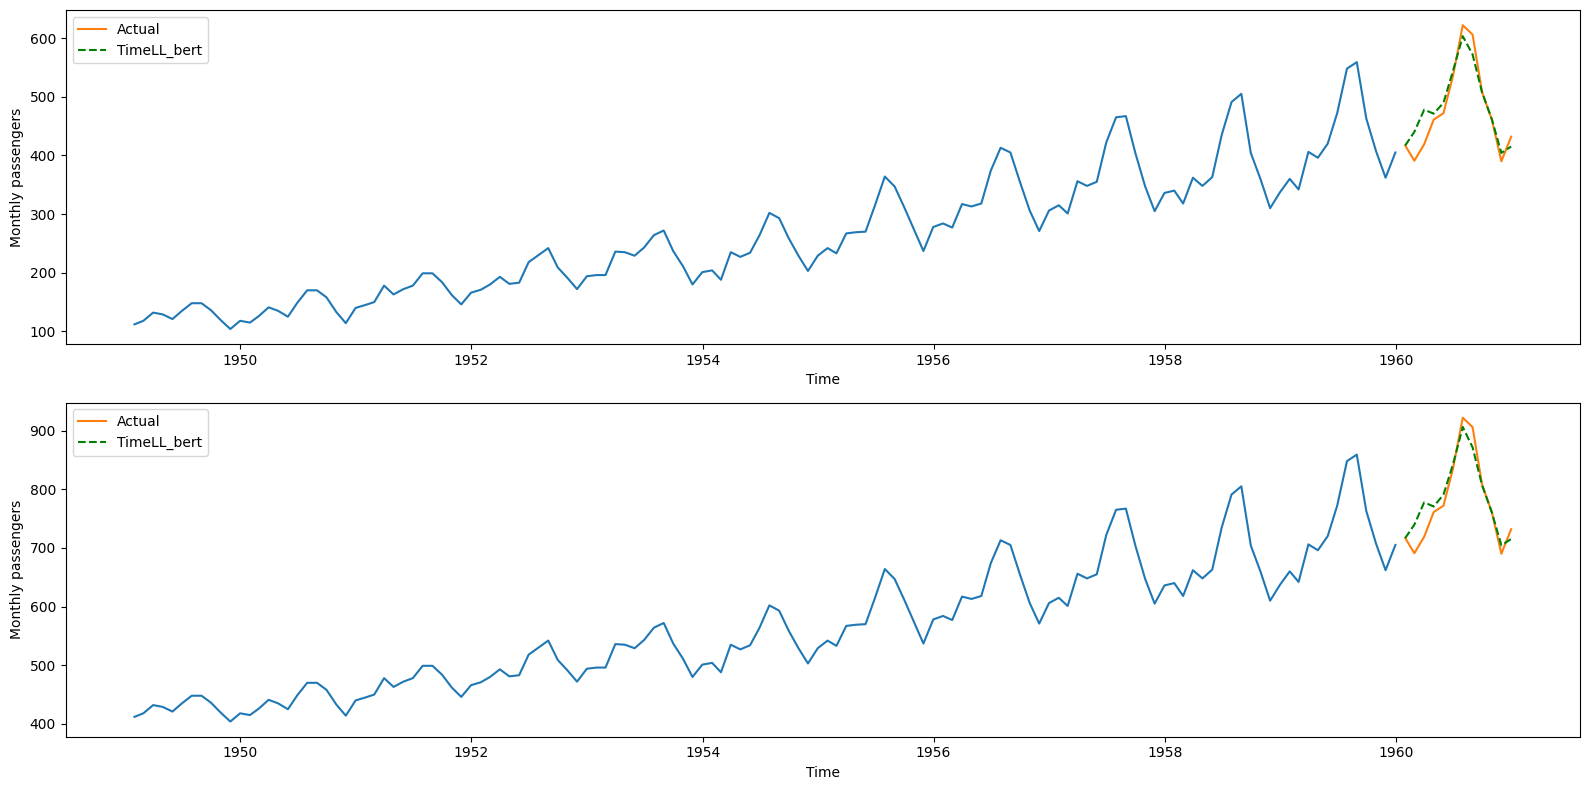

In [15]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
# ax1.plot(airline1_df['ds'], airline1_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
ax1.plot(airline1_df['ds'], airline1_df['TimeLL_bert'], label='TimeLL_bert', ls='--', color='green')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
# ax2.plot(airline2_df['ds'], airline2_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
ax2.plot(airline2_df['ds'], airline2_df['TimeLL_bert'], label='TimeLL_bert', ls='--', color='green')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()

## gpt2 1000 epochs

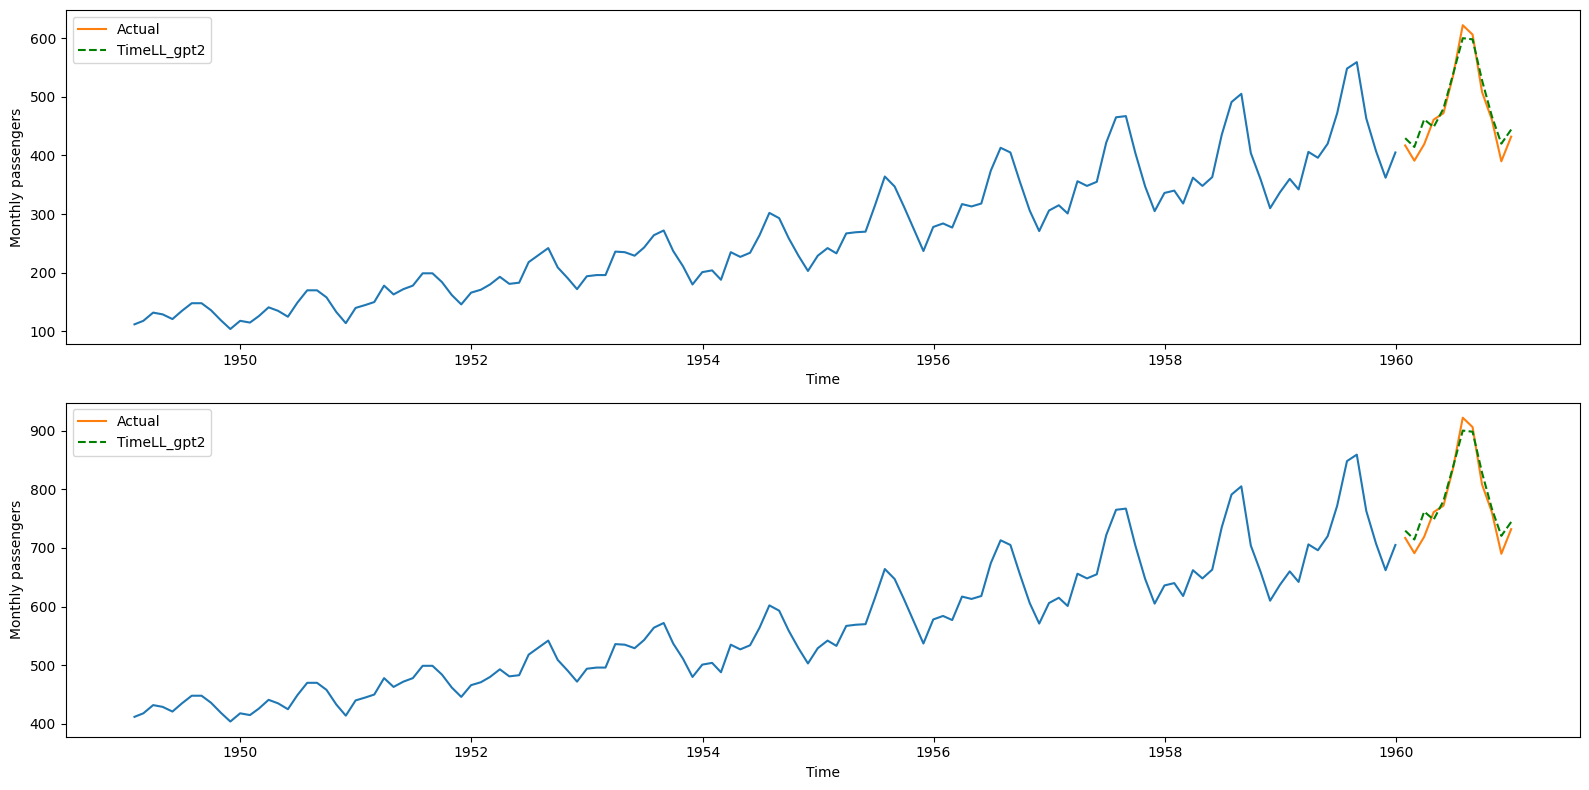

In [16]:
train1_df = Y_train_df[Y_train_df.unique_id == 'Airline1']
train2_df = Y_train_df[Y_train_df.unique_id == 'Airline2']

airline1_df = Y_test_df[Y_test_df.unique_id == 'Airline1']
airline2_df = Y_test_df[Y_test_df.unique_id == 'Airline2']

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(16,8))

ax1.plot(train1_df['ds'], train1_df['y'])
ax1.plot(airline1_df['ds'], airline1_df['y'], label='Actual')
ax1.plot(airline1_df['ds'], airline1_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
# ax1.plot(airline1_df['ds'], airline1_df['TimeLL_bert'], label='TimeLL_bert', ls='--', color='green')
ax1.legend(loc='best')
ax1.set_xlabel('Time')
ax1.set_ylabel('Monthly passengers')

ax2.plot(train2_df['ds'], train2_df['y'])
ax2.plot(airline2_df['ds'], airline2_df['y'], label='Actual')
ax2.plot(airline2_df['ds'], airline2_df['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
# ax2.plot(airline2_df['ds'], airline2_df['TimeLL_bert'], label='TimeLL_bert', ls='--', color='green')
ax2.legend(loc='best')
ax2.set_xlabel('Time')
ax2.set_ylabel('Monthly passengers')

plt.tight_layout()

In [16]:
output = "timellm_pred_airlines_bert_1000epochs_48layers"

if not os.path.exists(output):
    os.makedirs(output)

# Salva os DataFrames como arquivos CSV
Y_test_df.to_csv(f"{output}/test.csv", index=False)
Y_train_df.to_csv(f"{output}/train.csv", index=False)

# Showing loaded results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# gpt
output_gpt = "timellm_pred_airlines_gpt2_1000epochs_48layers"

Y_test_df_gpt = pd.read_csv(f"{output_gpt}/test.csv")
Y_test_df_gpt["ds"] = pd.to_datetime(Y_test_df_gpt["ds"])
Y_test_df_gpt = Y_test_df_gpt[Y_test_df_gpt["unique_id"]=="Airline1"]

# bert
output_bert = "timellm_pred_airlines_bert_1000epochs_48layers"

Y_test_df_bert = pd.read_csv(f"{output_bert}/test.csv")
Y_test_df_bert["ds"] = pd.to_datetime(Y_test_df_bert["ds"])
Y_test_df_bert = Y_test_df_bert[Y_test_df_bert["unique_id"]=="Airline1"]

# train
Y_train_df = pd.read_csv(f"{output_gpt}/train.csv")
Y_train_df["ds"] = pd.to_datetime(Y_train_df["ds"])
Y_train_df = Y_train_df[Y_train_df["unique_id"]=="Airline1"]

In [5]:
Y_test_df_gpt

,unique_id,ds,y,trend,y_[lag12],month,TimeLL_gpt2
0,Airline1,1960-01-31,417.000000,132.0,360.000031,-0.500000,429.377808
1,Airline1,1960-02-29,391.000031,133.0,342.000031,-0.409091,414.357605
2,Airline1,1960-03-31,419.000000,134.0,406.000000,-0.318182,461.410339
3,Airline1,1960-04-30,461.000000,135.0,395.999969,-0.227273,448.294525
4,Airline1,1960-05-31,472.000000,136.0,420.000000,-0.136364,480.005371
5,Airline1,1960-06-30,535.000000,137.0,472.000000,-0.045455,537.663818
6,Airline1,1960-07-31,622.000000,138.0,548.000000,0.045455,599.828552
7,Airline1,1960-08-31,606.000000,139.0,559.000000,0.136364,597.883362
8,Airline1,1960-09-30,508.000000,140.0,463.000031,0.227273,527.889099
9,Airline1,1960-10-31,461.000000,141.0,407.000000,0.318182,466.799957


In [4]:
Y_test_df_bert

,unique_id,ds,y,trend,y_[lag12],month,TimeLL_bert
0,Airline1,1960-01-31,417.00000,132.0,360.00003,-0.500000,416.88208
1,Airline1,1960-02-29,391.00003,133.0,342.00003,-0.409091,440.18338
2,Airline1,1960-03-31,419.00000,134.0,406.00000,-0.318182,477.92377
3,Airline1,1960-04-30,461.00000,135.0,395.99997,-0.227273,471.12866
4,Airline1,1960-05-31,472.00000,136.0,420.00000,-0.136364,489.63340
5,Airline1,1960-06-30,535.00000,137.0,472.00000,-0.045455,543.80300
6,Airline1,1960-07-31,622.00000,138.0,548.00000,0.045455,603.24524
7,Airline1,1960-08-31,606.00000,139.0,559.00000,0.136364,572.23010
8,Airline1,1960-09-30,508.00000,140.0,463.00003,0.227273,507.45250
9,Airline1,1960-10-31,461.00000,141.0,407.00000,0.318182,461.48750


### Plots

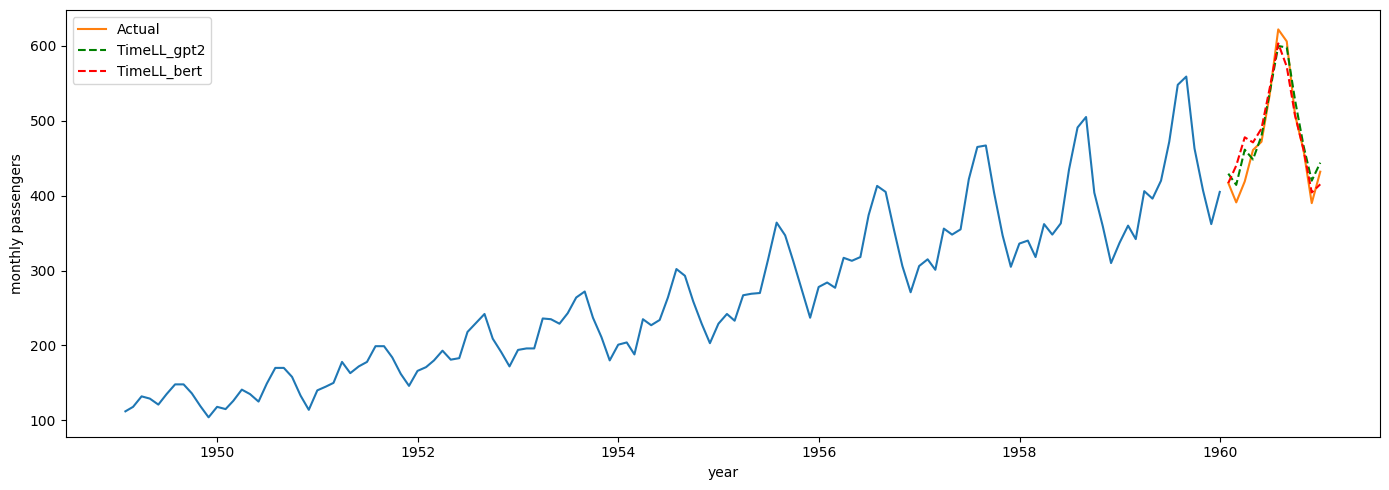

In [3]:
plt.figure(figsize=(14, 5))

plt.plot(Y_train_df['ds'], Y_train_df['y'])
plt.plot(Y_test_df_gpt['ds'], Y_test_df_gpt['y'], label='Actual')
plt.plot(Y_test_df_gpt['ds'], Y_test_df_gpt['TimeLL_gpt2'], label='TimeLL_gpt2', ls='--', color='green')
plt.plot(Y_test_df_bert['ds'], Y_test_df_bert['TimeLL_bert'], label='TimeLL_bert', ls='--', color='red')

plt.xlabel("year")
plt.ylabel("monthly passengers")
plt.legend()

plt.tight_layout()

### Errors

In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = Y_test_df_gpt['y']
y_pred_gpt = Y_test_df_gpt['TimeLL_gpt2']
y_pred_bert = Y_test_df_bert['TimeLL_bert']

# gpt metrics
mae_gpt = mean_absolute_error(y_true, y_pred_gpt)
rmse_gpt = np.sqrt(mean_squared_error(y_true, y_pred_gpt))
mse_gpt = mean_squared_error(y_true, y_pred_gpt)

# bert metrics
mae_bert = mean_absolute_error(y_true, y_pred_bert)
rmse_bert = np.sqrt(mean_squared_error(y_true, y_pred_bert))
mse_bert = mean_squared_error(y_true, y_pred_bert)

print(f"Mean Absolute Error (MAE) - GPT2: {mae_gpt}")
print(f"Root Mean Squared Error (RMSE) - GP2: {rmse_gpt}")
print(f"Root Mean Squared Error (RMSE) - GP2: {mse_gpt}")

print(f"Mean Absolute Error (MAE) - BERT: {mae_bert}")
print(f"Root Mean Squared Error (RMSE) - BERT: {rmse_bert}")
print(f"Root Mean Squared Error (RMSE) - BERT: {mse_bert}")

Mean Absolute Error (MAE) - GPT2: 16.627952575683604
Root Mean Squared Error (RMSE) - GP2: 19.920681026119485
Root Mean Squared Error (RMSE) - GP2: 396.8335325443968
Mean Absolute Error (MAE) - BERT: 19.121264037272145
Root Mean Squared Error (RMSE) - BERT: 26.397346963303104
Root Mean Squared Error (RMSE) - BERT: 696.8199267010076
